In [1]:
!wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" -O cert.crt -q

In [1]:
import os
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


try:
    import dotenv
    dotenv.load_dotenv()
except ImportError:
    pass

client = pymongo.MongoClient(
    host=os.environ['host'],
    port=27018,
    replicaSet='rs01',
    username=os.environ['username'],
    password=os.environ['password'],
    authSource=os.environ['database'],
    tls=True,
    tlsCAFile='cert.crt'
)
db = client[os.environ['database']]

In [2]:
id = 473
run = db.runs.find_one({'_id': id})
run

{'_id': 473,
 'experiment': {'name': 'sensor_test',
  'base_dir': '/home/amir/rqc_internship/UR5-Control',
  'sources': [['grid_toucher.py', ObjectId('631f47c3bb78c735ee127b90')]],
  'dependencies': ['numpy==1.23.2',
   'pymongo==4.2.0',
   'python-dotenv==0.21.0',
   'PyYAML==6.0',
   'sacred==0.8.2'],
  'repositories': [{'url': 'git@github.com:Hacker1337/UR5-Control.git',
    'commit': 'c698543bfd5fa58764e2483a5e13bfd71385a2b1',
    'dirty': True}],
  'mainfile': 'grid_toucher.py'},
 'format': 'MongoObserver-0.7.0',
 'command': 'touch_sensor',
 'host': {'hostname': 'amir-Lenovo',
  'os': ['Linux', 'Linux-5.15.0-46-generic-x86_64-with-glibc2.31'],
  'python_version': '3.10.6',
  'cpu': 'Intel(R) Core(TM) i7-4500U CPU @ 1.80GHz',
  'ENV': {}},
 'start_time': datetime.datetime(2022, 9, 12, 14, 52, 51, 53000),
 'config': {'ip': '10.201.2.179',
  'left_upper_corner': [0.445, -0.0695],
  'right_down_corner': [0.46, -0.1],
  'safe_hight': -0.0288,
  'sensor_hight': -0.0288,
  'max_sensor_de

In [5]:
[ x['name'] for x in list(db.metrics.find({'run_id': id}))]

['base_coordinate', 'force_z', 'vector_force', 'deformation', 'point_results']

In [6]:
points_curves = db.metrics.find_one({'_id': db.metrics.find_one({'run_id': id, 'name': 'point_results'})['_id']})['values']
point_res = points_curves[50]

In [7]:
point_res.keys()

dict_keys(['target_coordinate', 'base_coordinate', 'force_z', 'vector_force', 'deformation'])

### Force analyse

In [11]:

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

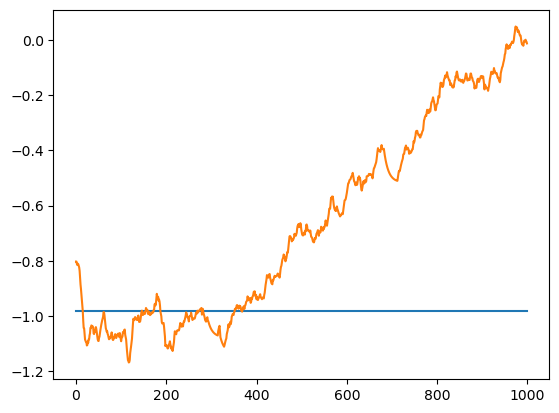

In [35]:
beg = 10
n = 2
step = 1
for i in range(beg, beg+n*step, step): 
    point_res = points_curves[i]
    plt.plot(smooth(point_res["force_z"], 0.9))

plt.show()

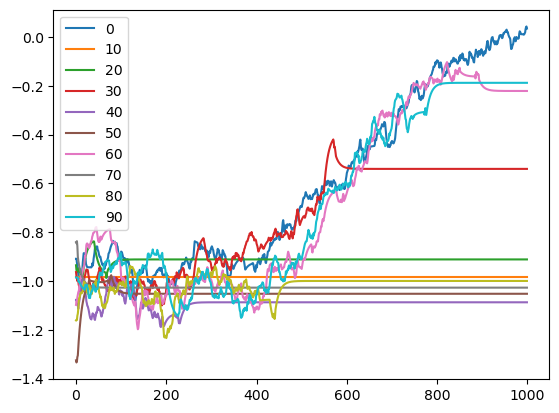

In [42]:
beg = 0
n = 100
step = 10
for i in range(beg, beg+n*step, step): 
    if i > len(points_curves):
        break
    point_res = points_curves[i]
    plt.plot(smooth(point_res["force_z"], 0.9), label=i)

plt.legend()
plt.show()

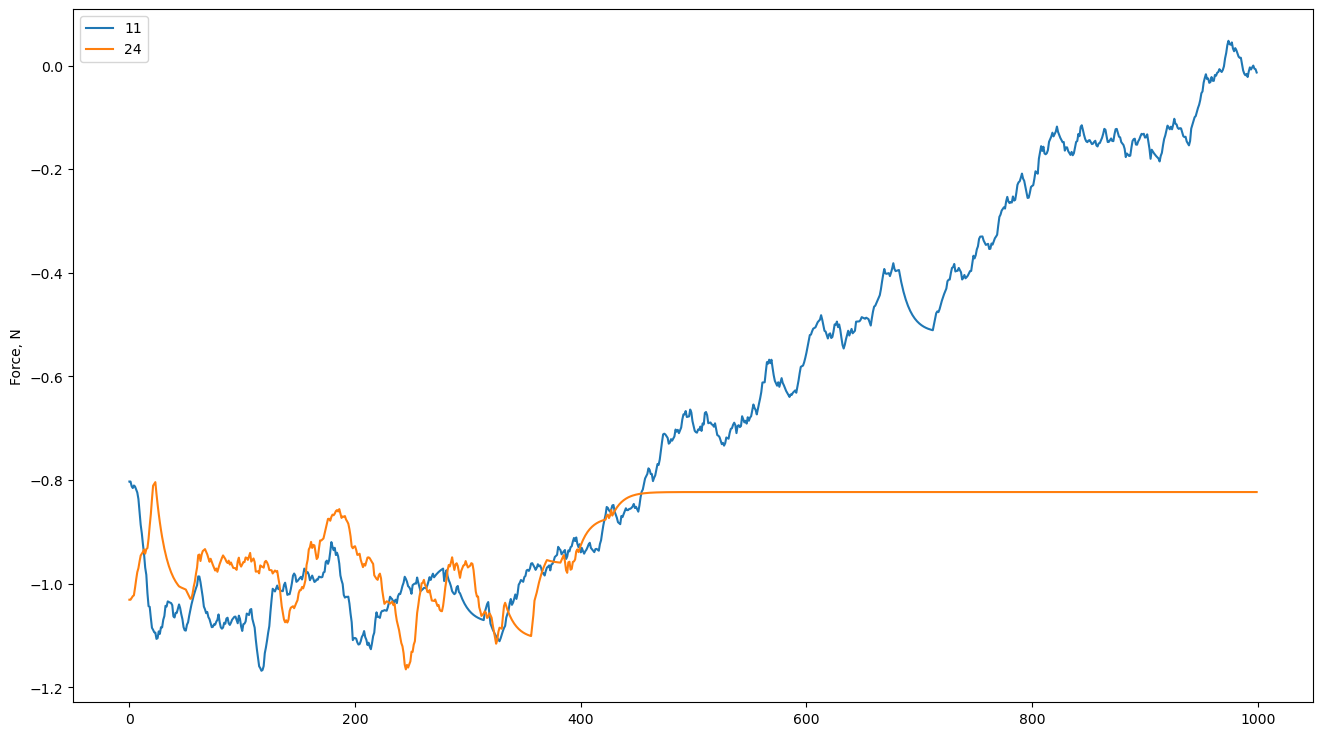

In [26]:
beg = 11
n = 2
step = 13
plt.figure(figsize=(16, 9))
plt.ylabel("Force, N")
for i in range(beg, beg+n*step, step): 
    if i > len(points_curves):
        break
    point_res = points_curves[i]
    data = point_res["force_z"]
    data = smooth(data, 0.9)
    plt.plot(data, label=i)

plt.legend()
# plt.savefig("forces.jpg", dpi=300)
plt.show()

### Sensor visualizing

In [5]:
def log_pars_func(point_res_dict):
    '''Returns max(absolute value) force'''
    return np.abs(point_res_dict['force_z']).max()
    
def sensor_plotting(id, log_parser_function):
    '''Plots 3d or heatmap visualization of spatial characteristics of sensor
    log_parser_function(dict_with_results_in_one_point) -> 1d value to visualize
    example:
    def log_pars_func(point_res_dict):
        """Returns max(absolute value) force"""
        return np.abs(point_res_dict['force_z']).max()
        
    '''
    points_curves = db.metrics.find_one({'_id': db.metrics.find_one({'run_id': id, 'name': 'point_results'})['_id']})['values']
    X = []
    Y = []
    Z = []
    for point_res in points_curves:
        xy = point_res['target_coordinate']
        X.append(xy[0])
        Y.append(xy[1])
        Z.append(log_parser_function(point_res))
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # ax.plot_surface(np.array(X).reshape(-1, 1)), np.array(Y).reshape(1, -1), np.array(Z).reshape())
    ax.scatter(np.array(X), np.array(Y), np.array(Z))
    plt.show()

<IPython.core.display.Javascript object>


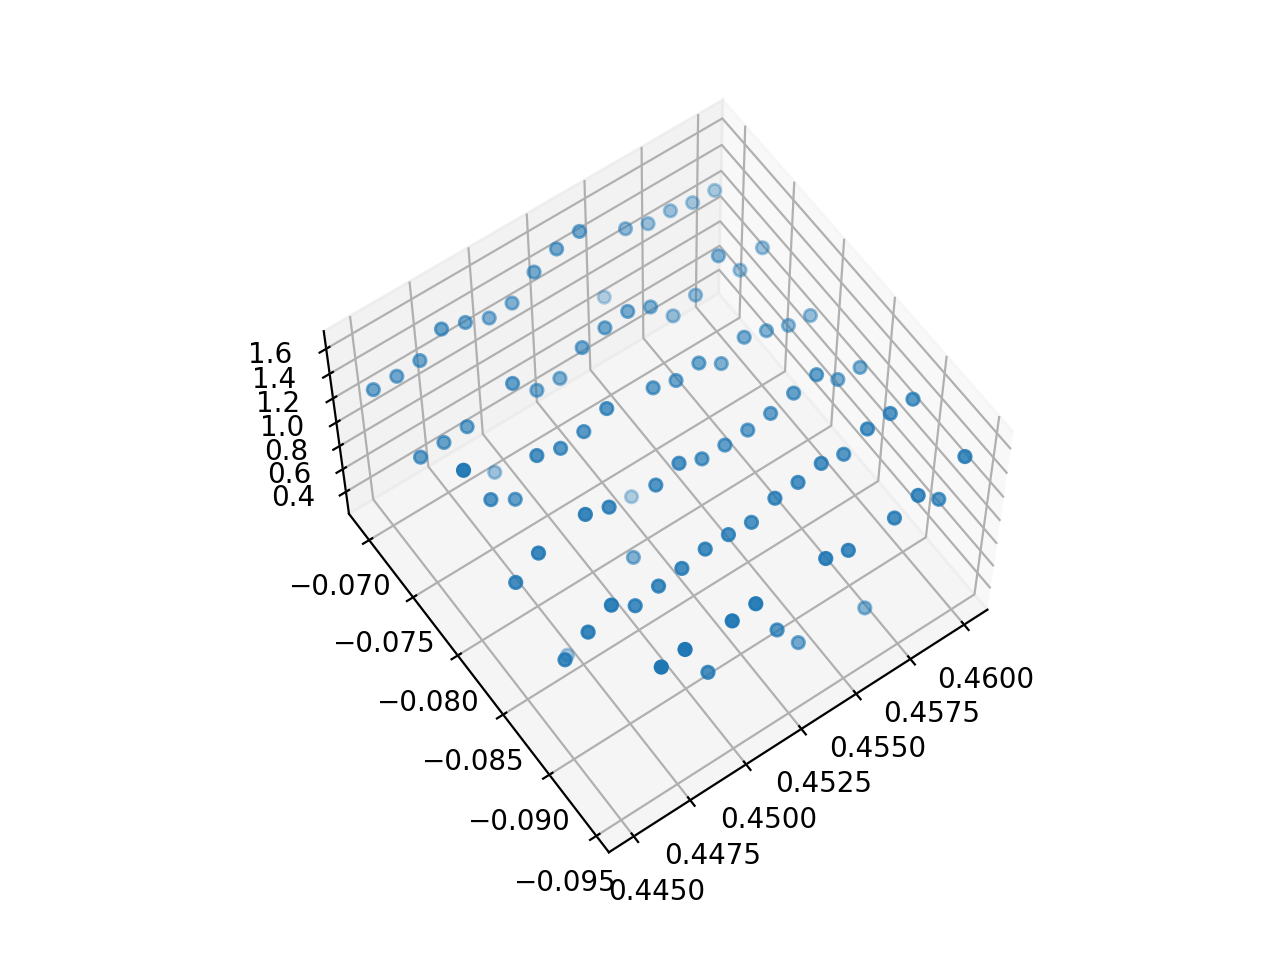

In [6]:
%matplotlib notebook
sensor_plotting(id, log_pars_func)

<IPython.core.display.Javascript object>


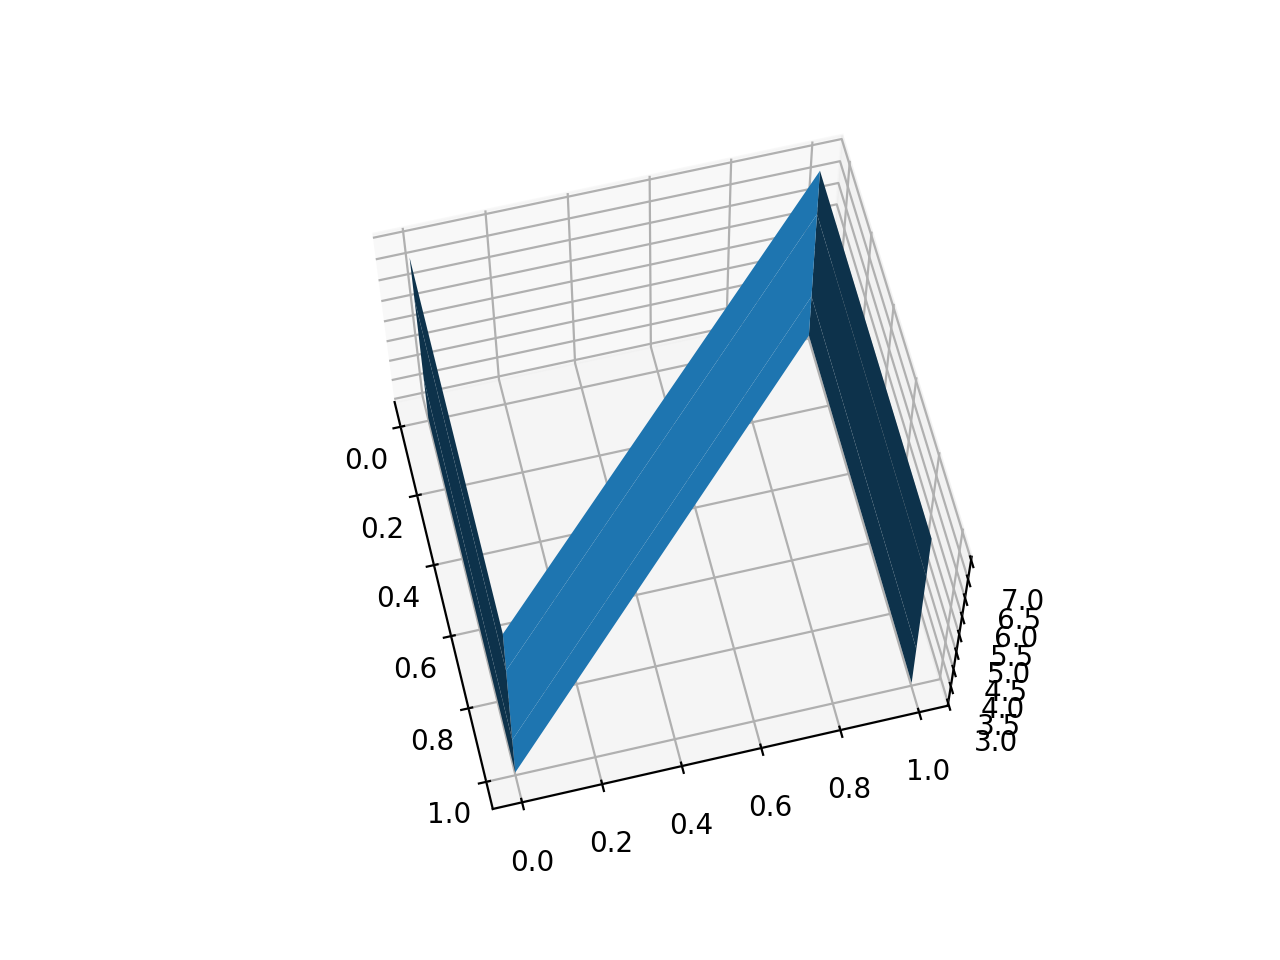

In [4]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(np.array([0, 1, 0, 1]).reshape((-1, 1)), np.array([0, 0, 1, 1]).reshape((-1, 1)), np.array([[3, 4, 6, 7]]))
# help(ax.plot_surface)

### next part